## Load Python Libraries

In [349]:
import torch
from torchvision import transforms
import torchvision.models as models
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, Subset, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

from scipy.stats import pearsonr

### Get a list of peptides

In [350]:
peptide_score_file = './data/training_peptide_PSSM_scores.txt'

def load_peptide_data(infile):

    peptides = list()
    PSSM_score = list()

    with open(infile) as f:
        for line in f:
            peptide, score = line.strip().split()
            peptides.append(list(peptide))
            PSSM_score.append(float(score))

    return peptides, PSSM_score

peptides, PSSM_score = load_peptide_data(peptide_score_file)

## One-hot encoding of the pepetides

In [351]:
def one_hot_encode_peptides(peptides):
    flattened_peptides = np.array(peptides).flatten().reshape(-1, 1)

    # Initialize the OneHotEncoder
    encoder = OneHotEncoder(categories=[list('ACDEFGHIKLMNPQRSTVWY')], sparse_output=False)

    # Transform the peptide sequences into a one-hot encoded format
    one_hot_encoded = encoder.fit_transform(flattened_peptides)

    # Reshape back into the original peptide sequence format
    num_peptides = len(peptides)
    peptide_length = len(peptides[0])
    one_hot_encoded_peptides = one_hot_encoded.reshape(num_peptides, peptide_length, -1)

    return one_hot_encoded_peptides

one_hot_encoded_peptides = one_hot_encode_peptides(peptides)

## Defining the model used

In [352]:
# Define model
class Linear_NN(torch.nn.Module):

    # 180 is given from the one-hot encoding of the 20 amino acids * 9 peptide length
    def __init__(self):
        super(Linear_NN, self).__init__()
        self.fc1 = torch.nn.Linear(180, 90)
        self.fc2 = torch.nn.Linear(90, 50)
        self.fc3 = torch.nn.Linear(50, 1)
        self.drop = torch.nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.drop(x)
        out = self.fc3(x)
        return out

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Define function to reset weight
Weight resetting aid to prevent the weight leakage

In [353]:
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        print(f'reset weight of layer {m}')
        m.reset_parameters()

### Loss function and optimizer

In [354]:
# Define the loss function 
criterion = torch.nn.MSELoss()

In [355]:
peptides_tensor = torch.tensor(one_hot_encoded_peptides, dtype=torch.float32).to(device)
PSSM_score_tensor = torch.tensor(np.asarray(PSSM_score).reshape(-1,1), dtype=torch.float32).to(device)

peptides_dataset = TensorDataset(peptides_tensor, PSSM_score_tensor)

In [356]:
def plot_loss(train_loss, val_loss, fold):
    plt.figure()
    plt.plot(train_loss, label='train err')
    plt.plot(val_loss, label='val err')
    plt.legend()
    plt.yscale('log')
    plt.style.use('seaborn-whitegrid')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(f'./loss/loss_fold_{fold}.png')
    plt.close()

In [358]:
torch.manual_seed(69)

kfold = KFold(n_splits=5, shuffle=True)

print("Starting KFold Cross Validation")

for fold, (train_ids, test_ids) in enumerate(kfold.split(peptides_dataset), 1):
    
    print(f'Fold {fold}')

    # Shuffle the data
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)

    # Define the data loaders
    train_loader = DataLoader(peptides_dataset, batch_size=10, sampler=train_subsampler)
    test_loader = DataLoader(peptides_dataset, batch_size=10, sampler=test_subsampler)

    # Initialize NN
    model = Linear_NN().to(device)
    model.apply(reset_weights)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    training_losses = []
    validation_losses = []

    for epoch in range(0, 100):
    
            print(f'Epoch {epoch+1}')

            training_loss = 0.0

            for i, data in enumerate(train_loader):
                  
                # Get the inputs
                inputs, labels = data

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs.view(-1, 180))

                # Calculate the loss
                loss = criterion(outputs, labels)

                # Backward pass
                loss.backward()

                # Optimize
                optimizer.step()

                training_loss += loss.item()
            
            with torch.no_grad():
                model.eval()
                validation_loss = 0.0

                for inputs, labels in test_loader:

                    outputs = model(inputs.view(-1, 180))
                    loss = criterion(outputs, labels)

                    validation_loss += loss.item()

            training_losses.append(training_loss/len(train_loader))
            validation_losses.append(validation_loss/len(test_loader))

            print(f'Training loss: {training_loss/len(train_loader)}')
            print(f'Validation Loss: {validation_loss/len(test_loader)}')

            
    # Save the model
    print('Finished Training, Saving Model')
    torch.save(model.state_dict(), f'./model/model_fold_{fold}.pt')

    # Plot the loss
    plot_loss(training_losses, validation_losses, fold) 
  
    

Starting KFold Cross Validation
Fold 1
reset weight of layer Linear(in_features=180, out_features=90, bias=True)
reset weight of layer Linear(in_features=90, out_features=50, bias=True)
reset weight of layer Linear(in_features=50, out_features=1, bias=True)
Epoch 1
Training loss: 19.17353608927776
Validation Loss: 10.600921984314919
Epoch 2
Training loss: 2.627593762788576
Validation Loss: 0.4102025318145752
Epoch 3
Training loss: 0.14514806140790282
Validation Loss: 0.11441241659224033
Epoch 4
Training loss: 0.03518792810686624
Validation Loss: 0.031000978648662567
Epoch 5
Training loss: 0.015912191836720276
Validation Loss: 0.022302857376635076
Epoch 6
Training loss: 0.011617341844518621
Validation Loss: 0.02071586450561881
Epoch 7
Training loss: 0.007633490424324787
Validation Loss: 0.017322564404457806
Epoch 8
Training loss: 0.00894437523765163
Validation Loss: 0.013936822889372707
Epoch 9
Training loss: 0.005398369931913528
Validation Loss: 0.01404979133978486
Epoch 10
Training lo

C:\Users\Chuan\AppData\Local\Temp\ipykernel_11812\1195006754.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Fold 2
reset weight of layer Linear(in_features=180, out_features=90, bias=True)
reset weight of layer Linear(in_features=90, out_features=50, bias=True)
reset weight of layer Linear(in_features=50, out_features=1, bias=True)
Epoch 1
Training loss: 19.254307793587753
Validation Loss: 13.906777420043944
Epoch 2
Training loss: 3.3371314275817774
Validation Loss: 0.3768458467721939
Epoch 3
Training loss: 0.14092301583090394
Validation Loss: 0.09023585930466652
Epoch 4
Training loss: 0.03655865452895613
Validation Loss: 0.04166515866294503
Epoch 5
Training loss: 0.01813762302788877
Validation Loss: 0.03032526755705476
Epoch 6
Training loss: 0.013927330773026134
Validation Loss: 0.029818616807460785
Epoch 7
Training loss: 0.010436875757655686
Validation Loss: 0.022294865846633913
Epoch 8
Training loss: 0.008419201770538138
Validation Loss: 0.037292981017380954
Epoch 9
Training loss: 0.009471563838383894
Validation Loss: 0.021565131116658448
Epoch 10
Training loss: 0.006805557324359021
Valid

C:\Users\Chuan\AppData\Local\Temp\ipykernel_11812\1195006754.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Fold 3
reset weight of layer Linear(in_features=180, out_features=90, bias=True)
reset weight of layer Linear(in_features=90, out_features=50, bias=True)
reset weight of layer Linear(in_features=50, out_features=1, bias=True)
Epoch 1
Training loss: 18.85334917442086
Validation Loss: 12.528187160491944
Epoch 2
Training loss: 2.713584614860028
Validation Loss: 0.47325438261032104
Epoch 3
Training loss: 0.1470432456045114
Validation Loss: 0.10383136346936225
Epoch 4
Training loss: 0.029699507039808427
Validation Loss: 0.05295970883220434
Epoch 5
Training loss: 0.016823038643648484
Validation Loss: 0.03517986262217164
Epoch 6
Training loss: 0.010889310144924932
Validation Loss: 0.03111862888559699
Epoch 7
Training loss: 0.00834792059577387
Validation Loss: 0.0318218888156116
Epoch 8
Training loss: 0.007173223698214081
Validation Loss: 0.02388472360558808
Epoch 9
Training loss: 0.007807345183556611
Validation Loss: 0.03730234574526548
Epoch 10
Training loss: 0.007270838138791397
Validation 

C:\Users\Chuan\AppData\Local\Temp\ipykernel_11812\1195006754.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Fold 4
reset weight of layer Linear(in_features=180, out_features=90, bias=True)
reset weight of layer Linear(in_features=90, out_features=50, bias=True)
reset weight of layer Linear(in_features=50, out_features=1, bias=True)
Epoch 1
Training loss: 19.528142732443268
Validation Loss: 12.42729808807373
Epoch 2
Training loss: 3.3690061954032515
Validation Loss: 0.39708948612213135
Epoch 3
Training loss: 0.14327947664813898
Validation Loss: 0.06395051734056324
Epoch 4
Training loss: 0.03315628350222694
Validation Loss: 0.032611070508137344
Epoch 5
Training loss: 0.01598971027439249
Validation Loss: 0.027475660368800163
Epoch 6
Training loss: 0.011008128679847134
Validation Loss: 0.021897016018629076
Epoch 7
Training loss: 0.008702630736413844
Validation Loss: 0.020069793555885552
Epoch 8
Training loss: 0.0070867469923129095
Validation Loss: 0.017491413569077848
Epoch 9
Training loss: 0.006759318273476104
Validation Loss: 0.01819809722714126
Epoch 10
Training loss: 0.006431268367282662
Val

C:\Users\Chuan\AppData\Local\Temp\ipykernel_11812\1195006754.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Fold 5
reset weight of layer Linear(in_features=180, out_features=90, bias=True)
reset weight of layer Linear(in_features=90, out_features=50, bias=True)
reset weight of layer Linear(in_features=50, out_features=1, bias=True)
Epoch 1
Training loss: 18.97559109913934
Validation Loss: 12.01240493774414
Epoch 2
Training loss: 2.742833489609748
Validation Loss: 0.44186893284320833
Epoch 3
Training loss: 0.16585435058691145
Validation Loss: 0.07180320173501968
Epoch 4
Training loss: 0.03601938929677624
Validation Loss: 0.0345240618288517
Epoch 5
Training loss: 0.015266281005340753
Validation Loss: 0.024754621712490918
Epoch 6
Training loss: 0.012428696598550401
Validation Loss: 0.02344749428331852
Epoch 7
Training loss: 0.009547497793916882
Validation Loss: 0.020859901942312718
Epoch 8
Training loss: 0.008553236905370177
Validation Loss: 0.01833166124051786
Epoch 9
Training loss: 0.006541175474940809
Validation Loss: 0.01824421134777367
Epoch 10
Training loss: 0.005620689235733265
Validatio

C:\Users\Chuan\AppData\Local\Temp\ipykernel_11812\1195006754.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Evaluating the model with unseen data

In [359]:
evaluation_data = './data/evaluation_peptide_PSSM_scores.txt'
# evaluation_data = '../data/data/PSSM/A0201.eval'
evaluation_peptides, evaluation_score = load_peptide_data(evaluation_data)
evaluation_one_hot_encoded_peptides = one_hot_encode_peptides(evaluation_peptides)

# Convert to tensors
evaluation_peptides_tensor = torch.tensor(evaluation_one_hot_encoded_peptides, dtype=torch.float32).to(device)
evaluation_score_tensor = torch.tensor(np.asarray(evaluation_score).reshape(-1,1), dtype=torch.float32).to(device)

evaluation_peptides_dataset = TensorDataset(evaluation_peptides_tensor, evaluation_score_tensor)


def test_model(models, evaluation_peptides_dataset):
    predictions = []

    evaluation_data_loader = DataLoader(evaluation_peptides_dataset, batch_size=10)

    with torch.no_grad():
        for model in models:
            model.eval()
            model_predictions = []

            for peptides, _ in evaluation_data_loader:
                peptides = peptides.to(device)
                outputs = model(peptides.view(-1, 180))
                model_predictions.extend(outputs.cpu().numpy())

            predictions.append(model_predictions)

    # Average predictions across models
    averaged_predictions = np.mean(predictions, axis=0)

    # Calculate total loss
    total_loss = criterion(torch.tensor(averaged_predictions, dtype=torch.float32).to(device), evaluation_score_tensor).item()

    return averaged_predictions, total_loss

# Load models
models = []
for i in range(1,6):
    model = Linear_NN().to(device)
    model.load_state_dict(torch.load(f'./model/model_fold_{i}.pt'))
    models.append(model)

# Test models
predictions, total_loss = test_model(models, evaluation_peptides_dataset)

print(f'Total Loss: {total_loss}')

Total Loss: 0.012524592690169811


## Saving evaluation data prediction result

In [360]:
outfile = './evaluation_result/evaluation_predictions.txt'

with open(outfile, 'w') as f:
    print('Peptide      Score      Prediction', file=f)
    for peptide, score, prediction in zip(evaluation_peptides, evaluation_score, predictions):
        print(f'{"".join(peptide):<12} {score:<10.4f} {prediction[0]:<10.4f}', file=f)

PCC:  0.999757426253449


C:\Users\Chuan\AppData\Local\Temp\ipykernel_11812\634076704.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid');


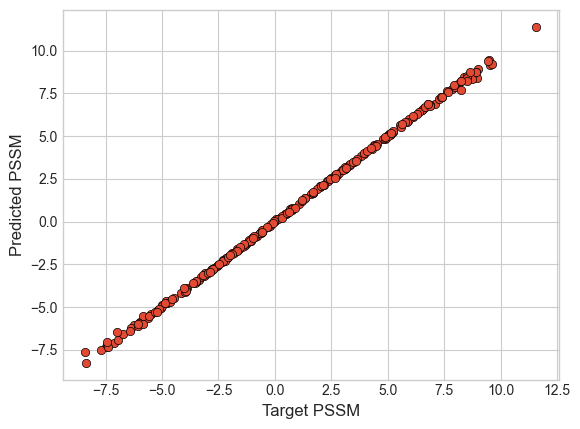

In [361]:
pcc = pearsonr(evaluation_score, np.array(predictions).flatten())
print("PCC: ", pcc[0])

plt.figure()
plt.style.use('seaborn-whitegrid');
plt.scatter(evaluation_score, predictions, edgecolors='black');
plt.xlabel('Target PSSM');
plt.ylabel('Predicted PSSM');
plt.savefig('./evaluation_result/evaluation_scatter.png')